In [2]:
!pip3 install pandas

  Using cached pandas-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Using cached pytz-2022.6-py2.py3-none-any.whl (498 kB)


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
# from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [7]:
PATH_TO_DATA = 'E:\KEDAR\code\Python\DL\New folder\DL Lab Assignments\DL4\ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 23-24: malformed \N character escape (<ipython-input-7-792a7a3506c1>, line 1)

In [ ]:
TARGET = 140
features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target)

In [ ]:
train_index = y_train[y_train ==1].index
train_data = x_train.loc[train_index]

In [ ]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [ ]:
class AutoEncoder(Model):
    def __init__(self, output_units, code_size=8):
        super().__init__()
        self.encoder = Sequential([
          Dense(64, activation='relu'),
          Dropout(0.1),
          Dense(32, activation='relu'),
          Dropout(0.1),
          Dense(16, activation='relu'),
          Dropout(0.1),
          Dense(code_size, activation='relu')
        ])
        self.decoder = Sequential([
          Dense(16, activation='relu'),
          Dropout(0.1),
          Dense(32, activation='relu'),
          Dropout(0.1),
          Dense(64, activation='relu'),
          Dropout(0.1),
          Dense(output_units, activation='sigmoid')
        ])
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

In [ ]:
history = model.fit(x_train_scaled, x_train_scaled, epochs=20, batch_size=512, validation_data=(x_test_scaled, x_test_scaled))

Epoch 1/20
5/5 [==============================] - 1s 40ms/step - loss: 0.0107 - mse: 0.0241 - val_loss: 0.0129 - val_mse: 0.0303
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0103 - mse: 0.0231 - val_loss: 0.0127 - val_mse: 0.0298
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0094 - mse: 0.0211 - val_loss: 0.0126 - val_mse: 0.0293
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0084 - mse: 0.0188 - val_loss: 0.0120 - val_mse: 0.0281
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0074 - mse: 0.0166 - val_loss: 0.0115 - val_mse: 0.0270
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0066 - mse: 0.0147 - val_loss: 0.0110 - val_mse: 0.0257
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0059 - mse: 0.0132 - val_loss: 0.0104 - val_mse: 0.0245
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0055 - mse: 0.0122 - val_loss: 

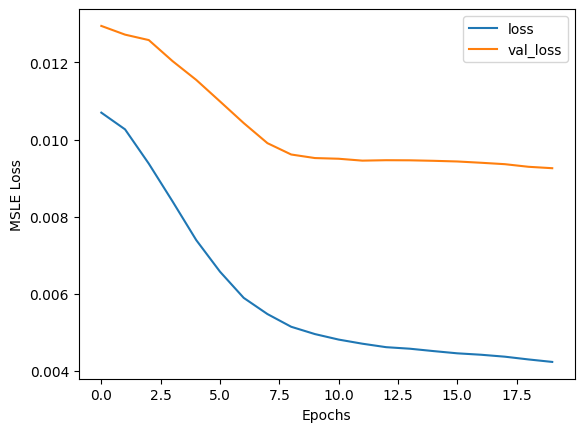

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
    return threshold

def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled)
    errors = tf.keras.losses.msle(predictions, x_test_scaled)
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

73/73 [==============================] - 0s 709us/step
Threshold: 0.009218903807754891
32/32 [==============================] - 0s 742us/step


0.949